In [12]:
import hades.aero.unsteady1D as uq
import hades.aero.riemann    as riem

In [13]:
from IPython.core.display import HTML ; HTML(open("./custom.css", "r").read()) # notebook style

# Shock generation


In [14]:
Pinit  = 1.e5
Pratio = 2.38
Tisoth = 293.15
r_air = 287.1
r_He  = 2078.
gam_air = 1.4
gam_He  = 5./3.
#
# driver gas (q20)
q20 = uq.unsteady_state(rho = Pinit*Pratio/(r_air*Tisoth),
                        u   = 0., 
                        p   = Pinit*Pratio, gamma=gam_air)
# driven gas (q10)
q10 = uq.unsteady_state(rho = Pinit/(r_air*Tisoth),
                        u   = 0., 
                        p   = Pinit, gamma=gam_air)
# Riemann problem
pb1 = riem.riemann_pb(q20, q10)
q21 = pb1.qstarL()
q11 = pb1.qstarR()
print "shock compression ratio:", q11.p/q10.p
print "shock Mach number      :", pb1.right_fastest()/q10.asound()

shock compression ratio: [ 1.52140515]
shock Mach number      : [ 1.20287934]


# Shock / Interface interaction

In [15]:
# Helium 
q00 = uq.unsteady_state(rho = Pinit/(r_He*Tisoth),
                        u   = 0., 
                        p   = Pinit, gamma=gam_He)
# Riemann problem
pb2 = riem.riemann_pb(q11, q00)
q12 = pb2.qstarL()
q01 = pb2.qstarR()
print "shock compression ratio:", q01.p/q00.p
print "interface speed        :", q12.u

shock compression ratio: [ 1.27676541]
interface speed        : [ 151.39935057]


# Shock reflexion

In [16]:
# define symmetric (ghost state) 
q01gh = q01.copysymmetric()
# Wall interaction
pbw = riem.riemann_pb(q01, q01gh)
q02 = pbw.qstarL()
print "shock compression ratio:", q02.p/q01.p
print "shock Mach number      :", pbw.left_fastest()/q01.asound()

shock compression ratio: [ 1.26224912]
shock Mach number      : [-0.95685193]


# Reshock of interface

In [17]:
# Riemann problem
pb3 = riem.riemann_pb(q12, q02)
q13 = pb3.qstarL()
q03 = pb3.qstarR()
print "interface speed        :", q13.u

interface speed        : [ 65.35507541]


# Position of interactions

In [18]:
# positions
x_int   = 2.5 
x_Rwall = 3.
x_Lwall = -1.
#
def xt_intersect(x1, t1, u1, x2, t2, u2):
    ti = (-x2+x1 + t2*u2-t1*u1)/(u2-u1)
    return x1+u1*(ti-t1), ti
#
# shock / interface 
t_shock_int  = x_int / pb1.right_fastest()
print "shock / interface   interaction at (x,t)=(%.3f,%.5f)"%(x_int, t_shock_int)
#
# shock / wall
t_shock_wall = (x_Rwall-x_int) / pb2.right_fastest() + t_shock_int
print "shock / wall        interaction at (x,t)=(%.3f,%.5f)"%(x_Rwall, t_shock_wall)
#
# interface / reshock
x_reshock, t_reshock = xt_intersect(x_int,   t_shock_int,  q12.u,
                                    x_Rwall, t_shock_wall, pbw.left_fastest())
print "interface / reshock interaction at (x,t)=(%.3f,%.5f)"%(x_reshock, t_reshock)
#
t_max = 1.2*t_reshock

shock / interface   interaction at (x,t)=(2.500,0.00605)
shock / wall        interaction at (x,t)=(3.000,0.00650)
interface / reshock interaction at (x,t)=(2.624,0.00687)


# x/t diagram

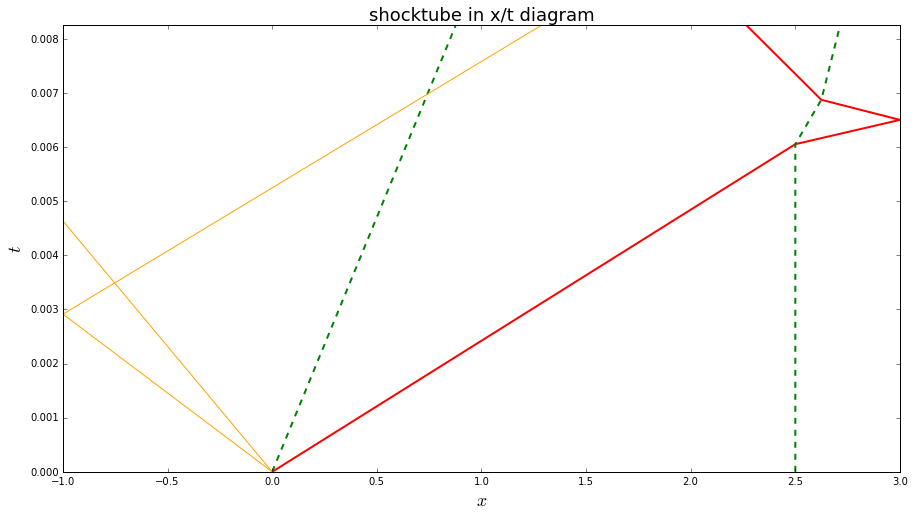

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
#
plt.figure(figsize=(15,8))
plt.axis([-1, 3, 0, t_max])
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r"$t$", fontsize=18)
plt.title(u"shocktube in x/t diagram", fontsize=18)
#
# plot shocks
plt.plot([0, x_int,       x_Rwall,      x_reshock, x_reshock+pb3.left_fastest()*(t_max-t_reshock)], 
         [0, t_shock_int, t_shock_wall, t_reshock, t_max],
         color="red", linewidth=2)
# plot interface
plt.plot([x_int, x_int,       x_reshock, x_reshock+q13.u*(t_max-t_reshock)],
         [0,     t_shock_int, t_reshock, t_max],
         color="green", linewidth=2, linestyle="dashed")
plt.plot([0, q11.u*t_max],
         [0, t_max],
         color="green", linewidth=2, linestyle="dashed")
# plot expansion
t_exp_wall = x_Lwall/q20.left_acoustic()
plt.plot([0, x_Lwall,    x_Lwall+q21.right_acoustic()*(t_max-t_exp_wall)],
         [0, t_exp_wall, t_max],
         color="orange", linewidth=1)
plt.plot([0, x_Lwall],
         [0, x_Lwall/q21.left_acoustic()],
         color="orange", linewidth=1)